In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from utils import *

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
df = pd.read_csv('./Data/adult.csv')
# import os
# default_n_threads = 1
# os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
# os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
# os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"
print("**Starting data processing** \n \n ")
def convert_marital_status(status):
    if status in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'married'
    elif status in ['Never-married', 'Separated', 'Widowed']:
        return 'single'
    else:
        return 'divorced'

df['marital-status'] = df['marital-status'].apply(convert_marital_status)

df['native-country'] = df['native-country'].replace('Outlying-US(Guam-USVI-etc)' , 'US Minor Islands')

df = df.drop(['capital-gain', 'capital-loss', 'fnlwgt'], axis=1)

income_mapping = {'<=50K': 0, '>50K': 1}
df['income'] = df['income'].map(income_mapping)


def fill_missing_categorical(df, column):
    df[column] = df[column].replace('?', np.nan)

    if df[column].notna().all():
        return df

    known = df[df[column].notna()]
    unknown = df[df[column].isna()]

    le = LabelEncoder()
    known[column] = le.fit_transform(known[column])
    X_known = known.drop(column, axis=1)
    y_known = known[column]

    categorical_cols = X_known.select_dtypes(include=['object']).columns

    le_cat = preprocessing.LabelEncoder()
    X_known[categorical_cols] = X_known[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    clf = RandomForestClassifier()
    clf.fit(X_known, y_known)

    X_unknown = unknown.drop(column, axis=1)

    X_unknown[categorical_cols] = X_unknown[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    unknown[column] = clf.predict(X_unknown)

    df = pd.concat([known, unknown], axis=0)

    df[column] = le.inverse_transform(df[column])
    
    return df

df = fill_missing_categorical(df, 'native-country')
df = fill_missing_categorical(df, 'occupation')
df = fill_missing_categorical(df, 'workclass')

Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['age'] < Q1 - 1.5 * IQR) | (df['age'] > Q3 + 1.5 * IQR)]

df.drop(outliers.index, inplace=True)
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df.drop(['age', 'hours-per-week'], axis=1, inplace=True)
df.reset_index(inplace=True)
columns_to_keep = ['workclass', 'educational-num', 'marital-status', 'occupation', 'gender', 'native-country', 'income']
Features = df[columns_to_keep]
X= Features

X = pd.get_dummies(X, columns=['workclass', 'marital-status', 'occupation', 'native-country'])

X = X.drop(columns=['income'])
y = df['income']


scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 =X1/np.linalg.norm(X1,axis =1).max()

X_fil = []
Y_fil = []

# ind  = y.values.sum()
ind = len(y.values)
counter = 0
print(ind)
for i in range(len(y.values)):
    if y.values[i] == 0:
        if counter < ind:
            X_fil.append(X1[i])
            Y_fil.append(y.values[i])
            counter+=1
    else:
        X_fil.append(X1[i])
        Y_fil.append(y.values[i])
        

import torch
x_train,x_test,y_train,y_test = train_test_split(X_fil,Y_fil,test_size = 0.2,random_state = 42)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

x_train_tensor = normalize2(x_train_tensor)
x_test_tensor = normalize2(x_test_tensor)

    
    







# knn = KNeighborsClassifier(n_neighbors=10)


# knn.fit(X_emb_train_priv, Y_train)

# y_pred = knn.predict(X_emb_test)
# print((y_pred == np.asarray(y_test_tensor)).sum()/len(y_pred))

**Starting data processing** 
 
 
48626


In [2]:
import torch
import torch.nn as nn

# Define the model architecture
model = nn.Sequential(
    nn.Linear(68, 64),  # Input layer with 100 input features and 64 output features
    nn.ReLU(),  # Activation function
    nn.Linear(64, 128),  # Hidden layer with 64 input features and 32 output features
    nn.ReLU(), 
    nn.Linear(128,32),  # Hidden layer with 64 input features and 32 output features
    nn.ReLU(),# Activation function
    nn.Linear(32, 1),
    nn.Sigmoid()# Output layer with 32 input features and 10 output features
)

# Print the model architecture
print(model)

Sequential(
  (0): Linear(in_features=68, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
  (7): Sigmoid()
)


In [3]:
print("\n \n** Formed Tensors and starting model training** \n \n ")
net = Net_new(1,device = torch.device('cuda:3'))
trainloader = torch.utils.data.DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=512, shuffle=False)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
net = net.to(device=torch.device('cuda:3'))

train_model_priv(net,trainloader,x_test_tensor,y_test_tensor,optimizer,1,0.8,device= torch.device('cuda:3'),print_cond = True,only_reg_flag=0,lr_schedular =None,lambda_loss=1)
outputs = net(x_test_tensor)
print(((outputs>0.5).squeeze().cpu() == y_test_tensor.squeeze()).sum()/(len(y_test_tensor)))





 
** Formed Tensors and starting model training** 
 
 


  0%|          | 0/1 [00:03<?, ?it/s]


Error: You must call wandb.init() before wandb.log()

In [ ]:
y_test_tensor.sum()/len(y_test_tensor)

tensor(0.2394)

In [ ]:
print("\n \n ** Creating embeddings ** \n \n ",len(y_train_tensor))
trainloader = torch.utils.data.DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=512, shuffle=False)
X_emb_train, losses_train = create_model_embs2(net,trainloader,device= torch.device('cuda:3'),l=len(y_train_tensor),h=0.8)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
# x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
testloader = torch.utils.data.DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=512, shuffle=False)
X_emb_test, losses_test = create_model_embs2(net,testloader,device= torch.device('cuda:3'),l=len(y_test_tensor),h=0.8)
losses_train,indices = torch.sort(losses_train)

# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
# x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)




 
 ** Creating embeddings ** 
 
  38900


In [ ]:

set_eps = 0.5
ind = (losses_train < set_eps).sum()

    


X_emb_train_priv = X_emb_train[indices][:ind]
Y_train = y_train_tensor[indices][:ind]

# input_size = 68
# model = LogisticRegression(input_size)
# Define the model architecture
num_epochs = 10
model = nn.Sequential(
    nn.Linear(68, 64),  # Input layer with 100 input features and 64 output features
    nn.ReLU(),  # Activation function
    nn.Linear(64, 128),  # Hidden layer with 64 input features and 32 output features
    nn.ReLU(), 
    nn.Linear(128,32),  # Hidden layer with 64 input features and 32 output features
    nn.ReLU(),# Activation function
    nn.Linear(32, 1),
    nn.Sigmoid()# Output layer with 32 input features and 10 output features
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainloader_priv = torch.utils.data.DataLoader(list(zip(X_emb_train_priv, Y_train)), batch_size=512, shuffle=True)
print("\n \n ** Starting final training ** \n \n ")
train_emb(model,trainloader_priv,X_emb_test,y_test_tensor,nn.BCELoss(),optimizer,num_epochs,device=torch.device('cuda:0'),test_total_loader = None,max_steps =10000)


 
 ** Starting final training ** 
 
 
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.8070)
Test Accuracy:  tensor(0.8225)
Test Accuracy:  tensor(0.8219)
Test Accuracy:  tensor(0.8277)
Test Accuracy:  tensor(0.8277)
Test Accuracy:  tensor(0.8273)
Test Accuracy:  tensor(0.8283)
Test Accuracy:  tensor(0.8278)


In [ ]:
input_size = 68
num_epochs = 50
# model = LogisticRegression(input_size)
model = nn.Sequential(
    nn.Linear(68, 64),  # Input layer with 100 input features and 64 output features
    nn.ReLU(),  # Activation function
    nn.Linear(64, 128),  # Hidden layer with 64 input features and 32 output features
    nn.ReLU(), 
    nn.Linear(128,32),  # Hidden layer with 64 input features and 32 output features
    nn.ReLU(),# Activation function
    nn.Linear(32, 1),
    nn.Sigmoid()# Output layer with 32 input features and 10 output features
)
from opacus import PrivacyEngine
privacy_engine = PrivacyEngine()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model2, optimizer2, data_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=trainloader,
    target_epsilon=1,
    target_delta =0.0001,
    epochs = num_epochs,
    max_grad_norm=1.0,
)
train_emb(model2,data_loader,x_test_tensor,y_test_tensor,nn.BCELoss(),optimizer2,num_epochs,device=torch.device('cuda:0'),max_steps =10000)

Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Accuracy:  tensor(0.7606)
Test Acc

In [ ]:
model = RandomForestClassifier(n_estimators=200)

# Train the model
model.fit(x_train_tensor, y_train_tensor)

# Make predictions
predictions = model.predict(x_test_tensor)
(predictions == np.array(y_test_tensor)).sum()/(len(y_test_tensor))

0.8252107752416205

In [ ]:
model = RandomForestClassifier(n_estimators=20)

# Train the model
model.fit(X_emb_train_priv, Y_train)

# Make predictions
predictions = model.predict(X_emb_test)
(predictions == np.array(y_test_tensor)).sum()/(len(y_test_tensor))

0.8240797861402427

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
# data = pd.read_csv('your_dataset.csv')

# # Split the dataset into features and target variable
# X = data.drop('income', axis=1)
# y = data['income']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = XGBClassifier()

model.fit(X_emb_train_priv, Y_train)

# Make predictions
predictions = model.predict(X_emb_test)

print("Accuracy:", (predictions == np.array(y_test_tensor)).sum()/(len(y_test_tensor)))

Accuracy: 0.8267530331071355


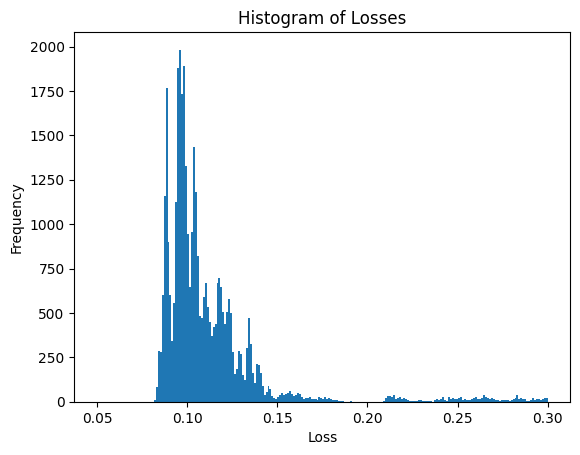

In [2]:
import os
import torch
model_path = 'Models/income_128_30'
def get_folders(directory):
    folders = []
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            folders.append(dir)
    return folders

# Specify the directory path
directory_path = './Embeddings'

# Call the function to get the directory names
directory_names = get_folders(directory_path)

if(model_path[7:] in directory_names):
    dirpth =  './Embeddings/'+model_path[7:]
    X_emb_train = torch.load(dirpth+'/X_emb_train.pt')
    X_emb_test = torch.load(dirpth+'/X_emb_test.pt')
    losses_train = torch.load(dirpth+'/losses_train.pt')
    losses_test = torch.load(dirpth+'/losses_test.pt')
    
import matplotlib.pyplot as plt

# Assuming losses_test is a list or array containing the loss values


# Filter the losses within the range of 0 and 2
filtered_losses = [loss for loss in losses_train if 0 <= loss <= 2]

# Plot the histogram
plt.hist(filtered_losses, bins=230, range=(0.05, 0.3))
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Losses')
plt.show()